<a href="https://colab.research.google.com/github/NgocMinhUniversityProjects/ML_MR/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [220]:
import numpy as np
import matplotlib.pyplot as plt

In [221]:
epsilon = 1e-14

# Normal baum-welch

In [222]:
def forward(obs, A, B, pi):
    N = A.shape[0]
    T = len(obs)
    alpha = np.zeros((T, N))
    alpha[0, :] = pi * B[:, obs[0]]
    for t in range(1, T):
        for j in range(N):
            alpha[t, j] = np.sum(alpha[t-1, :] * A[:, j]) * B[j, obs[t]]
    return np.sum(alpha[-1, :]), alpha

In [223]:
def backward(obs, A, B):
    N = A.shape[0]
    T = len(obs)
    beta = np.zeros((T, N))
    beta[T-1, :] = 1
    for t in range(T-2, -1, -1):
        for i in range(N):
            beta[t, i] = np.sum(A[i, :] * B[:, obs[t+1]] * beta[t+1, :])

    return beta

In [224]:
# obs : short for observation sequence
# N : number of hidden states
# M : number of possible symbols

def baum_welch(obs, N, M, n_iter=100, returnLog = False):
    T = len(obs)
    A = np.random.dirichlet(np.ones(N), size=N)
    B = np.random.dirichlet(np.ones(M), size=N)
    pi = np.random.dirichlet(np.ones(N))

    A_arr = []
    B_arr = []
    pi_arr = []
    prob_arr = []

    for iteration in range(n_iter):
        P,alpha=forward(obs,A,B,pi)
        beta = backward(obs, A, B)

        if returnLog:
          A_arr.append(A)
          B_arr.append(B)
          pi_arr.append(pi)
          prob_arr.append(P)

        xi = np.zeros((T - 1, N, N))
        for t in range(T - 1):
            denom = (alpha[t][:, None] * A * B[:, obs[t + 1]] * beta[t + 1]).sum()
            xi[t] = (alpha[t][:, None] * A * B[:, obs[t + 1]] * beta[t + 1]) / denom
        gamma = xi.sum(axis=2)
        gamma = np.vstack([gamma, (alpha[-1] * beta[-1]) / P])

        pi = gamma[0]
        A = xi.sum(axis=0) / (gamma[:-1].sum(axis=0)[:, None])

        for k in range(M):
            B[:, k] = gamma[np.array(obs) == k].sum(axis=0)
        B = B / (gamma.sum(axis=0)[:, None])

    if returnLog:
      return A_arr, B_arr, pi_arr, prob_arr

    return A, B, pi # Guessed parameters

# Scaled baum-welch

In [225]:
def forward_log_scaled(obs, A, B, pi):
    N = A.shape[0]
    T = len(obs)
    alpha = np.zeros((T, N))
    c = np.zeros(T)   # scaling factors

    alpha[0, :] = pi * B[:, obs[0]]
    c[0] = 1.0 / np.sum(alpha[0, :])
    alpha[0, :] *= c[0]

    for t in range(1, T):
        for j in range(N):
            alpha[t, j] = np.sum(alpha[t-1, :] * A[:, j]) * B[j, obs[t]]
        c[t] = 1.0 / np.sum(alpha[t, :])
        alpha[t, :] *= c[t]

    log_prob = -np.sum(np.log(c)) # Apply log
    return log_prob, alpha, c


In [226]:
def backward_log_scaled(obs, A, B, c):
    N = A.shape[0]
    T = len(obs)
    beta = np.zeros((T, N))

    beta[T-1, :] = c[T-1]   # scale

    for t in range(T-2, -1, -1):
        for i in range(N):
            beta[t, i] = np.sum(A[i, :] * B[:, obs[t+1]] * beta[t+1, :])
        beta[t, :] *= c[t]   # apply scaling

    return beta


In [227]:
def baum_welch_scaled(obs, N, M, max_iter=100, returnLog = False):
    T = len(obs)

    A = np.random.dirichlet(np.ones(N), size=N)
    B = np.random.dirichlet(np.ones(M), size=N)
    pi = np.random.dirichlet(np.ones(N))

    A_arr = []
    B_arr = []
    pi_arr = []
    prob_arr = []


    for iteration in range(max_iter):
        log_prob, alpha, c = forward_log_scaled(obs, A, B, pi)
        beta = backward_log_scaled(obs, A, B, c)

        if(returnLog):
          A_arr.append(A)
          B_arr.append(B)
          pi_arr.append(pi)
          prob_arr.append(log_prob)

        xi = np.zeros((T-1, N, N))
        for t in range(T-1):
            denom = np.sum(alpha[t][:, None] * A * B[:, obs[t+1]] * beta[t+1])
            if denom == 0: denom = epsilon
            xi[t] = (alpha[t][:, None] * A * B[:, obs[t+1]] * beta[t+1]) / denom

        # Remnomalizes gamma
        gamma = alpha * beta
        gamma /= gamma.sum(axis=1, keepdims=True)

        pi = gamma[0]
        A = xi.sum(axis=0) / (gamma[:-1].sum(axis=0)[:, None] + epsilon)

        for k in range(M):
            mask = np.array(obs) == k
            if np.any(mask):
                B[:, k] = gamma[mask].sum(axis=0)
        B = B / (gamma.sum(axis=0)[:, None] + epsilon)

    if returnLog:
      return A_arr, B_arr, pi_arr, prob_arr

    return A, B, pi


# Viterbi

In [228]:
# obs : short for observation sequence
# A : transition probability matrix N x N
# B : state emission probability matrix N x M
# pi : initial distribution

def viterbi(obs, A, B, pi):
    N = A.shape[0]
    T = len(obs)
    delta = np.zeros((T, N)) # Max probability array for any sequence to end in state index i
    psi = np.zeros((T, N), dtype=int) # argmax back pointer

    delta[0, :] = pi * B[:, obs[0]]

    for t in range(1, T):
        for j in range(N):
            seq_probs = delta[t-1, :] * A[:, j]
            psi[t, j] = np.argmax(seq_probs)
            delta[t, j] = np.max(seq_probs) * B[j, obs[t]]

    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(delta[-1, :])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]

    return states, delta, psi

# Test HMM for predicition

In [229]:
def predict_next(obs, A, B, pi, length=1, random=True):
    # log_prob, alpha, c = forward_log_scaled(obs, A, B, pi)
    # returns the states visited as well

    _,alpha=forward(obs, A, B, pi)
    state_dist = alpha[-1, :] / np.sum(alpha[-1, :])

    predictions = []
    states = []
    for _ in range(length):
        next_state_dist = state_dist @ A
        next_obs_dist = next_state_dist @ B

        # normalize both
        next_state_dist /= np.sum(next_state_dist)
        next_obs_dist /= np.sum(next_obs_dist)

        if(random):
          next_obs = np.random.choice(len(next_obs_dist), p=next_obs_dist)
          next_state = np.random.choice(len(next_state_dist), p=next_state_dist)
          state_dist = np.zeros_like(state_dist)
          state_dist[next_state] = 1.0
        else :
          next_state = np.argmax(next_state_dist)
          next_obs = np.argmax(next_obs_dist)
          state_dist = next_state_dist

        states.append(next_state)
        predictions.append(next_obs)

    return predictions, states


In [230]:
def max_likelihood_obs(A, B, pi, len = 10):
  obs = []
  start_state = np.argmax(pi)
  obs.append(start_state)
  return predict_next(obs, A, B, pi, len, False)

# Test and visualize

In [231]:
def viewHMM(A, B, pi):
  fig, ax = plt.subplots(1, 3, figsize=(16, 4))

  # --- Transition matrix A ---
  im = ax[0].imshow(A, cmap="viridis")
  ax[0].set_title("Transition Matrix A")
  ax[0].set_xlabel("To state")
  ax[0].set_ylabel("From state")
  fig.colorbar(im, ax=ax[0])

  # --- Emission matrix B ---
  im = ax[1].imshow(B, cmap="plasma")
  ax[1].set_title("Emission Matrix B")
  ax[1].set_xlabel("Emission")
  ax[1].set_ylabel("State")
  fig.colorbar(im, ax=ax[1])

  # --- Initial distribution pi ---
  ax[2].bar(range(len(pi)), pi)
  ax[2].set_title("Initial Distribution π")
  ax[2].set_xlabel("State")
  ax[2].set_ylabel("Probability")

  plt.tight_layout()
plt.show()

## Plot log probability of baum-welch over time

In [232]:
def plot_prob(prob_arr, max_iter):
  plt.plot(np.arange(max_iter), prob_arr)
  plt.xlabel("Iteration")
  plt.ylabel("Log Probability")
  plt.show()

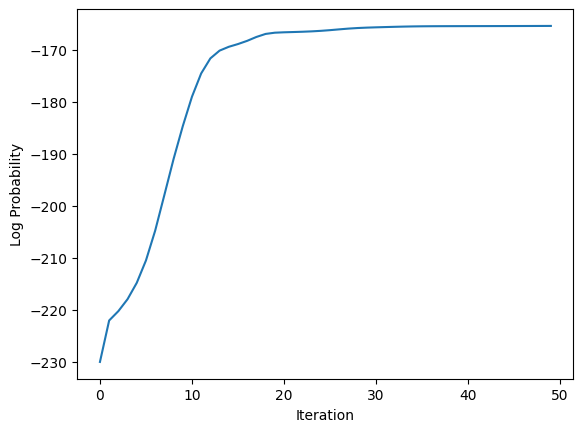

In [233]:
obs = np.random.randint(0, 10, 100)
N = 10
M = 10

max_iter = 50

A_arr, B_arr, pi_arr, prob_arr = baum_welch_scaled(obs, N, M, max_iter, True)
plot_prob(prob_arr, max_iter)

# probability should monotonically increases
# then flatten
# this graph is good

## Compare a maximum likelihood observation with viterbi output (fixxed HMM)

In [234]:
# 2 x 2 HMM model
A_original = np.array([[0.7, 0.3], [0.4, 0.6]])
B_original = np.array([[0.1, 0.9], [0.9, 0.1]])
pi_original = np.array([0.5, 0.5])

A = A_original
B = B_original
pi = pi_original

print("Original:", A, B, pi)

obs, states = max_likelihood_obs(A, B, pi, 100)
print("Test observation (len = 10):", obs)

A_v, _, _ = viterbi(obs, A, B, pi)

print("States visited:", states)
print("Viterbi output (len = 10):", A_v)

diff = A_v - states

print("Number of differences:", np.count_nonzero(diff))

# No difference --> viterbi behaves correctly

Original: [[0.7 0.3]
 [0.4 0.6]] [[0.1 0.9]
 [0.9 0.1]] [0.5 0.5]
Test observation (len = 10): [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int6

## Compare test HMM with one obtained from baum-welch with maximum likely observation

Max-likelihood observation from original (len = 100): [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(

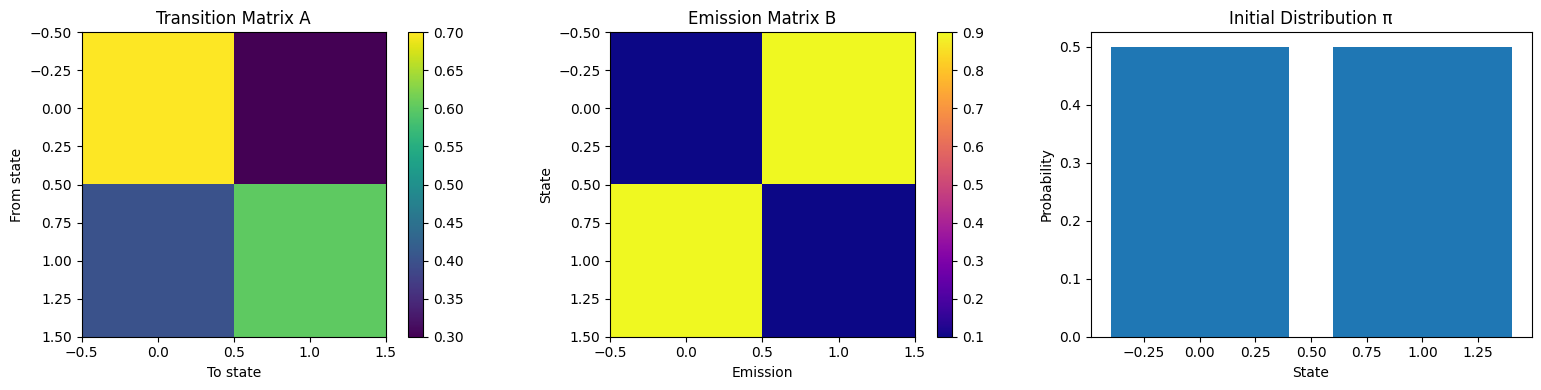

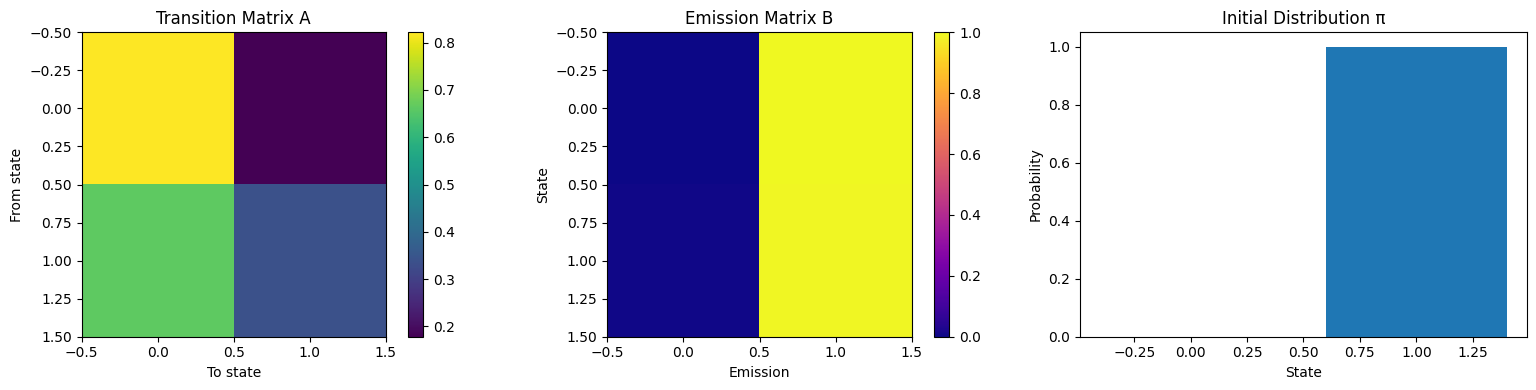

In [235]:
viewHMM(A, B, pi)

obs, states = max_likelihood_obs(A, B, pi, 1000)
print("Max-likelihood observation from original (len = 100):", obs)

M = 2
N = 2

A, B, pi = baum_welch_scaled(obs, N, M, 50)

viewHMM(A, B, pi)

obs2, states2 = max_likelihood_obs(A, B, pi, 1000)
print("Max-likelihood observation from obtained (len = 100):", obs2)

# compare obs
diff = np.subtract(obs2, obs)

print("Number of differences in observation:", np.count_nonzero(diff))

# compare states

diff = np.subtract(states2, states)

print("Number of differences in states traveled:", np.count_nonzero(diff))

## Compares learned A, B and pi to the original

In [236]:
from itertools import permutations

def best_permutation_match(A_true, B_true, pi_true, A_learn, B_learn, pi_learn):
    """
    Return permutation of learned states that best matches true states
    by minimizing Frobenius distance of (A,B,pi) combined.
    """
    N = A_true.shape[0]
    assert A_learn.shape == (N,N)
    best_perm = None
    best_score = np.inf

    # try scipy Hungarian for speed if available
    try:
        from scipy.optimize import linear_sum_assignment
        # build cost matrix: cost[i,j] = distance between true state i and learned state j
        cost = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                # distance between rows/cols of A, rows of B, and pi entries
                da = np.linalg.norm(A_true[i,:] - A_learn[j,:]) + np.linalg.norm(A_true[:,i] - A_learn[:,j])
                db = np.linalg.norm(B_true[i,:] - B_learn[j,:])
                dp = abs(pi_true[i] - pi_learn[j])
                cost[i,j] = da + db + dp
        row_ind, col_ind = linear_sum_assignment(cost)
        # col_ind maps true state i -> learned state col_ind[i]
        perm = list(col_ind)
        # construct permutation array p where new_index = perm[old_index]
        best_perm = perm
    except Exception:
        # brute force (ok for small N <= 6)
        for perm in permutations(range(N)):
            perm = list(perm)
            # apply perm to learned matrices (permute rows and columns)
            A_p = A_learn[np.ix_(perm, perm)]
            B_p = B_learn[perm,:]
            pi_p = pi_learn[perm]
            score = np.linalg.norm(A_true - A_p) + np.linalg.norm(B_true - B_p) + np.linalg.norm(pi_true - pi_p)
            if score < best_score:
                best_score = score
                best_perm = perm

    return best_perm

def permute_learned(A_learn, B_learn, pi_learn, perm):
    A_p = A_learn[np.ix_(perm, perm)]
    B_p = B_learn[perm, :]
    pi_p = pi_learn[perm]
    return A_p, B_p, pi_p

def compare(A_true, B_true, pi_true, A_learn, B_learn, pi_learn):
    # Align permutation
    perm = best_permutation_match(A_true, B_true, pi_true, A_learn, B_learn, pi_learn)
    A_p, B_p, pi_p = permute_learned(A_learn, B_learn, pi_learn, perm)

    # Compute L1/L2
    results = {}
    results['perm'] = perm
    results['A_L1'] = np.linalg.norm(A_true - A_p, ord=1)
    results['A_L2'] = np.linalg.norm(A_true - A_p)
    results['B_L1'] = np.linalg.norm(B_true - B_p, ord=1)
    results['B_L2'] = np.linalg.norm(B_true - B_p)
    results['pi_L1'] = np.linalg.norm(pi_true - pi_p, ord=1)
    results['pi_L2'] = np.linalg.norm(pi_true - pi_p)

    # KL (careful with zeros)
    eps = 1e-12
    def kl(p, q):
        p = np.clip(p, eps, 1)
        q = np.clip(q, eps, 1)
        return np.sum(p * np.log(p / q))
    results['A_KL'] = np.sum([kl(A_true[i], A_p[i]) for i in range(A_true.shape[0])])
    results['B_KL'] = np.sum([kl(B_true[i], B_p[i]) for i in range(B_true.shape[0])])
    results['pi_KL'] = kl(pi_true, pi_p)

    return results

def state_confusion(true_states, inferred_states, perm=None):
    # If perm provided, remap inferred states
    if perm is not None:
        inv_map = {perm[i]: i for i in range(len(perm))}  # learned->true idx
        remapped = np.array([inv_map[s] for s in inferred_states])
    else:
        remapped = np.array(inferred_states)
    # confusion matrix
    N = max(true_states.max(), remapped.max()) + 1
    conf = np.zeros((N,N), dtype=int)
    for t, r in zip(true_states, remapped):
        conf[t, r] += 1
    return conf


def summarize(stats):
    def assess_L2(x):
        if x < 0.05:
            return "very close"
        elif x < 0.2:
            return "slightly different"
        elif x < 0.5:
            return "moderately different"
        else:
            return "significantly different"

    def assess_KL(x):
        if x < 0.1:
            return "distributions almost identical"
        elif x < 1:
            return "slightly different distributions"
        elif x < 5:
            return "noticeably different distributions"
        else:
            return "very different distributions"

    print("=== HMM Parameter Difference Summary ===")
    print(f"State permutation mapping used: {stats.get('perm')}")

    # -------- A --------
    print("\n[Transition Matrix A]")
    print(f"  L2 difference: {stats['A_L2']:.4f} → {assess_L2(stats['A_L2'])}")
    print(f"  KL divergence: {stats['A_KL']:.4f} → {assess_KL(stats['A_KL'])}")

    # -------- B --------
    print("\n[Emission Matrix B]")
    print(f"  L2 difference: {stats['B_L2']:.4f} → {assess_L2(stats['B_L2'])}")
    print(f"  KL divergence: {stats['B_KL']:.4f} → {assess_KL(stats['B_KL'])}")

    # -------- pi --------
    print("\n[Initial Distribution π]")
    print(f"  L2 difference: {stats['pi_L2']:.4f} → {assess_L2(stats['pi_L2'])}")
    print(f"  KL divergence: {stats['pi_KL']:.4f} → {assess_KL(stats['pi_KL'])}")

    # -------- high-level conclusion --------
    print("\n=== Interpretation ===")

    # A
    if stats['A_L2'] < 0.2 and stats['A_KL'] < 1:
        print("• Transition matrix A was recovered well.")
    else:
        print("• Transition matrix A differs noticeably.")

    # B
    if stats['B_KL'] > 5:
        print("• Emission matrix B is numerically very different (expected for EM),")
        print("  but may still produce the same prediction behavior.")
    elif stats['B_L2'] < 0.2:
        print("• Emission matrix B is close to original.")
    else:
        print("• Emission matrix B is moderately different.")

    # π
    if stats['pi_KL'] > 5:
        print("• Initial distribution π changed a lot (expected, since long sequences make π irrelevant).")
    else:
        print("• π is reasonably close to the original.")

    print("========================================")

compare_res = compare(A_original, B_original, pi_original, A, B, pi)

print("Comparison stat:")
print(compare_res)
summarize(compare_res)

Comparison stat:
{'perm': [np.int64(0), np.int64(1)], 'A_L1': np.float64(0.3830648995452428), 'A_L2': np.float64(0.40767898067236635), 'B_L1': np.float64(0.995310278686058), 'B_L2': np.float64(1.2740333552312564), 'pi_L1': np.float64(1.0), 'pi_L2': np.float64(0.7071067811865476), 'A_KL': np.float64(0.18592964423914762), 'B_KL': np.float64(6.939550147727244), 'pi_KL': np.float64(13.12236337740433)}
=== HMM Parameter Difference Summary ===
State permutation mapping used: [np.int64(0), np.int64(1)]

[Transition Matrix A]
  L2 difference: 0.4077 → moderately different
  KL divergence: 0.1859 → slightly different distributions

[Emission Matrix B]
  L2 difference: 1.2740 → significantly different
  KL divergence: 6.9396 → very different distributions

[Initial Distribution π]
  L2 difference: 0.7071 → significantly different
  KL divergence: 13.1224 → very different distributions

=== Interpretation ===
• Transition matrix A differs noticeably.
• Emission matrix B is numerically very differ

## View states traveled

In [237]:
def plot_state_path(states, title="State Path"):
    T = len(states)
    plt.figure(figsize=(14, 10))

    plt.step(range(T), states, where='post')
    plt.yticks(sorted(np.unique(states)))
    plt.xlabel("Time")
    plt.ylabel("State")
    plt.title(title)
    plt.grid(True, alpha=0.3)

    plt.show()

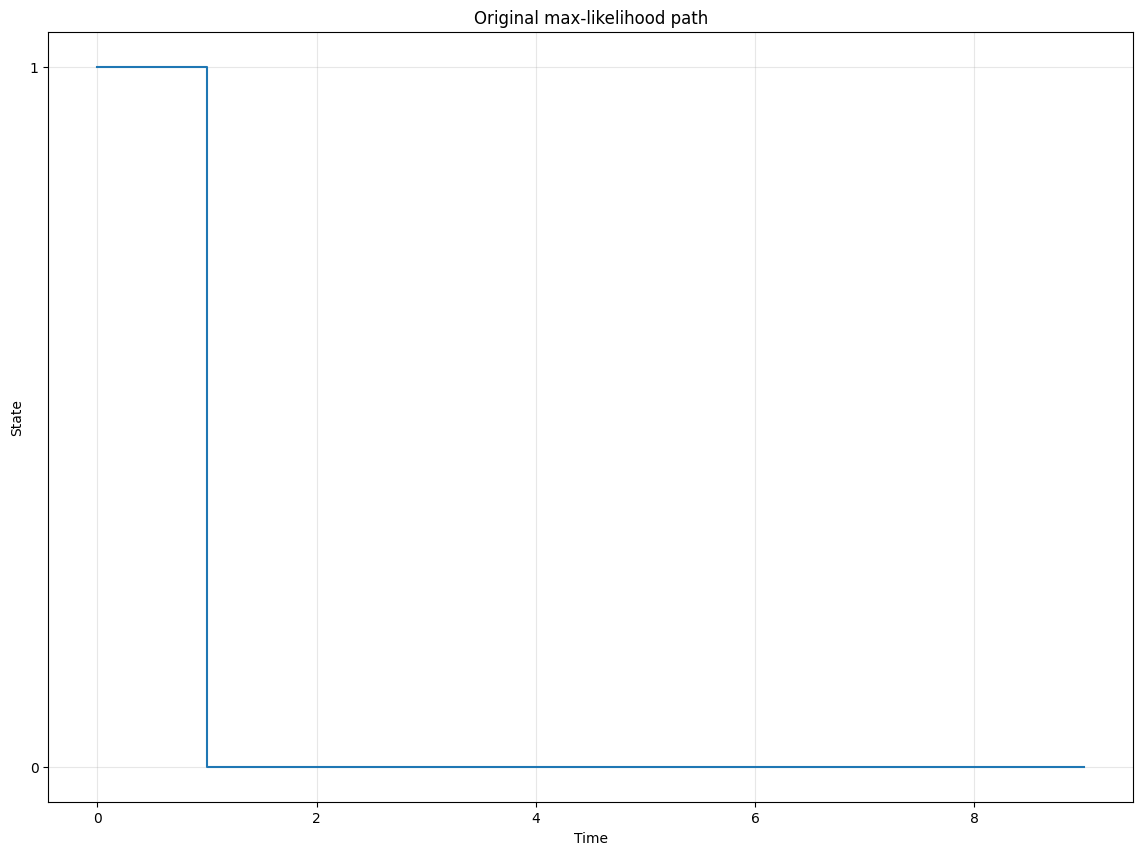

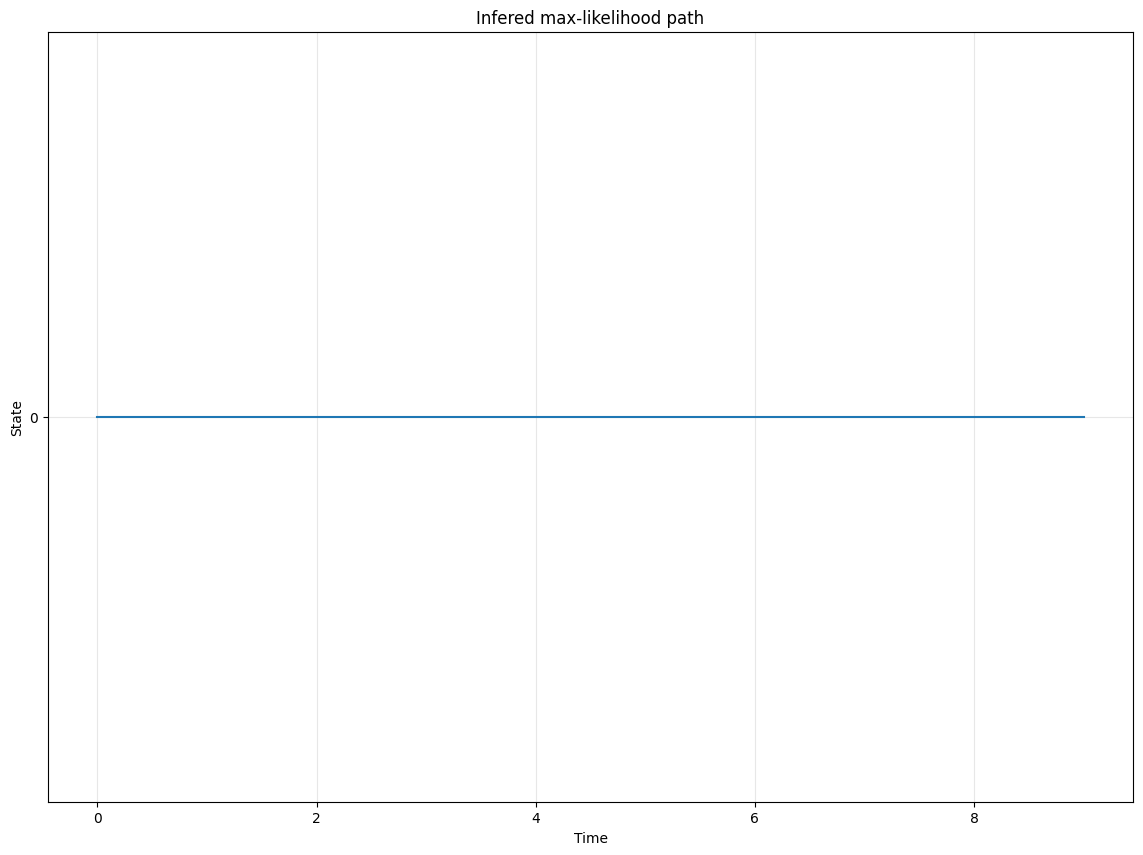

In [238]:
plot_state_path(states[:10], "Original max-likelihood path")
plot_state_path(states2[:10], "Infered max-likelihood path")

## Visualize a more complex HMM - Weather

In [245]:
# 0 = clear / sunny
# 1 = clouddy
# 2 = rainny
# Real weather for the past 2 weeks, each entries is 6 hours, entered at sep 29, 2025
# Manually enteredd from https://www.timeanddate.com/weather/vietnam/ho-chi-minh/historic

symbols = ["☀️", "⛅", "☔"]
obs = [1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 2, 1, 1, 0, 0, 0, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2]

N = 100 # pure guess, 2 humidity level * 5 temperatures * 10
M = 3
A_arr, B_arr, pi_arr, prob_arr = baum_welch_scaled(obs, N, M, 100, True)

A = A_arr[-1]
B = B_arr[-1]
pi = pi_arr[-1]

### Prediction

In [246]:
print("Random next sequences:")
for i in range(10):
  prediction, _ =  predict_next(obs, A, B, pi, 10)
  print([symbols[i] for i in prediction])

print("")

print("Maximum likely next sequence")
max_likelihood_prediction, states = predict_next(obs, A, B, pi, 50, False)
print([symbols[i] for i in max_likelihood_prediction])

Random next sequences:
['☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '⛅', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☀️', '☔', '☔', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☀️', '☔', '☔', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☀️', '☔', '⛅', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '⛅', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☀️', '☔', '⛅', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '⛅', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☀️', '☔', '☔', '⛅']
['☔', '☔', '☔', '☔', '☔', '☔', '☀️', '☔', '⛅', '⛅']

Maximum likely next sequence
['☔', '☔', '☔', '☔', '☔', '☔', '☔', '☔', '⛅', '⛅', '⛅', '☔', '⛅', '☀️', '☀️', '☔', '☔', '☔', '☀️', '☔', '⛅', '⛅', '⛅', '⛅', '⛅', '☀️', '☔', '☔', '☔', '☔', '☔', '⛅', '⛅', '☀️', '⛅', '⛅', '⛅', '☀️', '☔', '☔', '☔', '☔', '☔', '☔', '⛅', '⛅', '⛅', '☔', '⛅', '☔']


### View probability

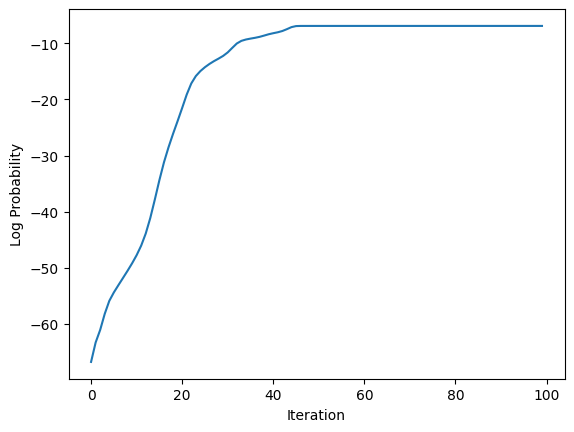

In [247]:
plot_prob(prob_arr, 100)

### View HMM

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


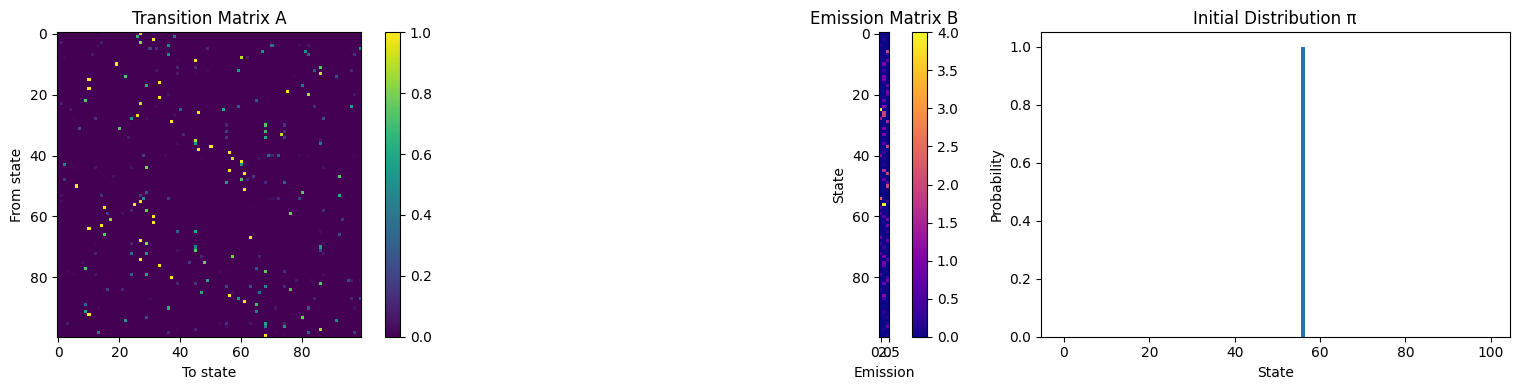

In [248]:
viewHMM(A, B, pi)
print(pi)

### View states:

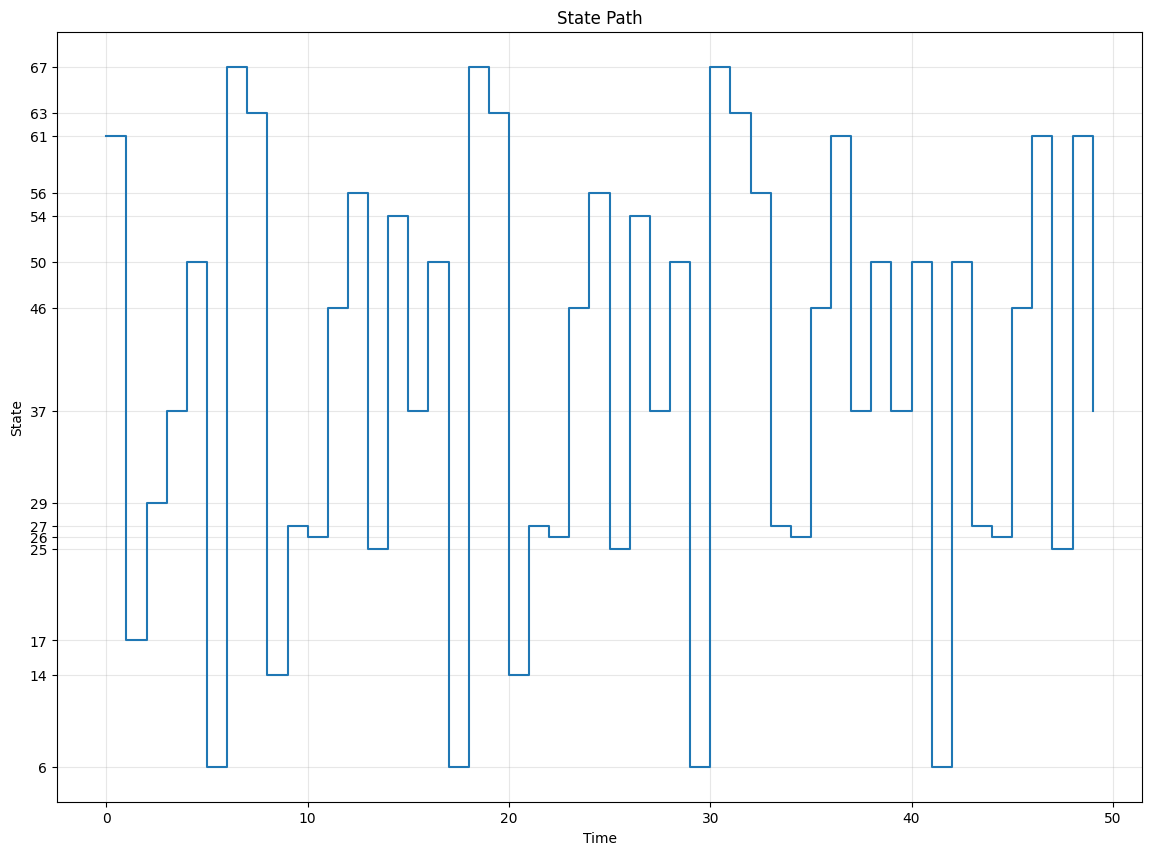

In [249]:
plot_state_path(states)


# Task : POS labeling

In [244]:
import nltk
import numpy as np
from hmmlearn.hmm import  CategoricalHMM
from sklearn.model_selection import train_test_split
import warnings

ModuleNotFoundError: No module named 'hmmlearn'


##  Tải và chuẩn bị dữ liệu

In [ ]:
nltk.download('universal_tagset')
tagged_sents = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

print(f"Total sents: {len(tagged_sents)}")
print("Example:", tagged_sents[0])
print("-" * 30)
train_sents, test_sents = train_test_split(tagged_sents, test_size=0.2, random_state=42)

print(f"Train: {len(train_sents)}")
print(f"Test: {len(test_sents)}")

## Xây dựng Vocabulary và Ánh xạ (Mappings)

In [ ]:


vocab = set()
tags = set()
for sent in train_sents:
    for word, tag in sent:
        vocab.add(word)
        tags.add(tag)

vocab.add("<UNK>")
UNK_TOKEN = "<UNK>"


word_to_id = {word: i for i, word in enumerate(vocab)}
tag_to_id = {tag: i for i, tag in enumerate(tags)}

id_to_word = {i: word for word, i in word_to_id.items()}
id_to_tag = {i: tag for tag, i in tag_to_id.items()}

UNK_ID = word_to_id[UNK_TOKEN]

N = len(tags)
M = len(vocab)

print(f"Number of tags: {N}")
print(f"Number of observations: {M}")
print("Tags:", tags)


## Huấn luyện (Tính toán A, B, pi) - Supervised Training

In [ ]:


pi = np.zeros(N) + 1
A = np.zeros((N, N)) + 1
B = np.zeros((N, M)) + 1
for sent in train_sents:
    if not sent:
        continue

    start_tag_id = tag_to_id[sent[0][1]]
    pi[start_tag_id] += 1

    for i in range(len(sent)):
        word, tag = sent[i]
        word_id = word_to_id.get(word, UNK_ID)
        tag_id = tag_to_id[tag]

        B[tag_id, word_id] += 1

        if i < len(sent) - 1:
            next_tag = sent[i+1][1]
            next_tag_id = tag_to_id[next_tag]
            A[tag_id, next_tag_id] += 1
pi = pi / np.sum(pi)
A = A / np.sum(A, axis=1, keepdims=True)
B = B / np.sum(B, axis=1, keepdims=True)





## Đánh giá mô hình (Evaluation)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

total_words = 0
correct_words = 0
all_true_tags = []
all_pred_tags = []

for sent in test_sents:
    if not sent:
        continue
    obs_sequence = []
    true_tags_ids = []

    for word, tag in sent:
        word_id = word_to_id.get(word, UNK_ID)
        obs_sequence.append(word_id)
        true_tags_ids.append(tag_to_id[tag])

    predicted_tags_ids, _, _ = viterbi(obs_sequence, A, B, pi)

    all_true_tags.extend(true_tags_ids)
    all_pred_tags.extend(predicted_tags_ids)

    for true_tag, pred_tag in zip(true_tags_ids, predicted_tags_ids):
        total_words += 1
        if true_tag == pred_tag:
            correct_words += 1

accuracy = (correct_words / total_words) * 100 if total_words else 0
print(f"Total words: {total_words}")
print(f"Correct words: {correct_words}")
true_labels = [id_to_tag[i] for i in all_true_tags]
pred_labels = [id_to_tag[i] for i in all_pred_tags]
tag_names = list(tag_to_id.keys())
print(classification_report(true_labels, pred_labels))

cm = confusion_matrix(true_labels, pred_labels, labels=tag_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=tag_names, yticklabels=tag_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Accuracy = {accuracy:.2f}%)")
plt.show()


In [ ]:
!pip install hmmlearn